In [1]:
!python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
INFO: pip is looking at multiple versions of networkx to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
   ---------------------------------------- 0.0/2.6 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 GB 5.6 MB/s eta 0:07:43
   ---------------------------------------- 0.0/2.6 GB 5.9 MB/s eta 0:07:17
   ---------------------------------------- 0.0/2.6 GB 5.6 MB/s eta 0:07:42
   ---------------------------------------- 0.0/2.6 GB 5.9 MB/s eta 0:07:20
   ---------------------------------------- 0.0/2.6 GB 5.6 MB/s eta 0:07:42
   ---------------------------------------- 0.0/2.6 GB 6.0 MB/s eta 0:07:12
   ---------------------------------------- 0.0/2.6 GB 6.0 MB/s eta 0:07:10
   ---------

In [ ]:
import zipfile
from PIL import Image
import torch
from torchvision import transforms
from io import BytesIO
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("GPU is", "available" if device else "NOT AVAILABLE")

# Caminho para o arquivo ZIP
zip_path1 = 'class_t.zip'
zip_path2 = 'class_n3.zip'

# Transforms para redimensionar e converter para tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converte para [C x H x W]
])

# Lista para armazenar os tensores
image_in_tensors = []
image_out_tensors = []


# Abre o ZIP e processa as imagens diretamente
def loadImages(zip_path,label,max):
    count = 0
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                with zip_ref.open(file_name) as file:
                    image = Image.open(BytesIO(file.read())).convert('RGB')
                    tensor = transform(image)  # Shape: [3, 256, 256]
                    #print(tensor.shape)
                    image_in_tensors.append(tensor)
                    image_out_tensors.append([label])
                count+=1
                if count%1000 == 0:
                    print(count)
                    
                if count >= max:
                    return

# Empilha os tensores em um batch
loadImages(zip_path1,1,5000)
loadImages(zip_path2,0,5000)

print(f'Total de imagens carregadas: {len(image_in_tensors)}')

t_x = torch.stack(image_in_tensors)
t_y = torch.tensor(image_out_tensors,dtype=torch.float32)

shuffler = np.random.permutation(len(t_x))

x_shuffled = t_x[shuffler]
y_shuffled = t_y[shuffler]

tlen = len(x_shuffled)
l = int(tlen*0.3) #20%
xa = x_shuffled[0:l]
ya = y_shuffled[0:l]

xb = x_shuffled[l:tlen]
yb = y_shuffled[l:tlen]

t_xt = xa.to(device)
t_yt = ya.to(device)



dataset = TensorDataset(t_xt, t_yt)
#batch_tensor = torch.stack(image_in_tensors)  # Shape: [N, 3, 256, 256]


print(f'Shape do batch: {t_xt.shape}')
print(f'Shape dos rótulos: {t_yt.shape}')



GPU is available
1000
2000
Total de imagens carregadas: 2541
Shape do batch: torch.Size([762, 3, 256, 256])
Shape dos rótulos: torch.Size([762, 1])


In [31]:
import torch;
import torch.nn as nn

class Avaliadora(nn.Module):
    def __init__(self):
        super(Avaliadora, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, stride=1) # 252x252
        self.poll1 = nn.MaxPool2d(2,2) # 126x126
        self.conv2 = nn.Conv2d(6, 12, 3, stride=1) # 124x124
        self.poll2 = nn.MaxPool2d(2,2) # 62x62
        self.conv3 = nn.Conv2d(12, 24, 15, stride=1) # 48x48
        self.poll3 = nn.MaxPool2d(4,4) # 12x12
        
        self.linear1 = nn.Linear(3456,256)
        self.linear2 = nn.Linear(256,1)
        #self.linear3 = nn.Linear(164,164)
        #self.linear4 = nn.Linear(512,1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.poll1(x)
        x = self.conv2(x)
        x = self.poll2(x)
        x = self.conv3(x)
        x = self.poll3(x)
        
        #print("x poll1: ",x.size())
        
        x = torch.flatten(x, start_dim=1)
        
        #print("x flatten: ",x.size())
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        
        #x = torch.relu(self.linear1(x))
        #x = torch.relu(self.linear2(x))
        #x = torch.tanh(self.linear3(x))
        #x = torch.relu(self.linear4(x))
        return x

class Geradora(nn.Module):
    def __init__(self):
        super(Geradora, self).__init__()

        self.linear1 = nn.Linear(10,256)
        self.linear2 = nn.Linear(256,3456)

        #24x12x12
        self.unpool1 = nn.ConvTranspose2d(24,24,4, stride=4) # 48x48
        self.trans1 = nn.ConvTranspose2d(24, 12, 15, stride=1)
        self.unpool2 = nn.ConvTranspose2d(12,12,2, stride=2) # 48x48
        self.trans2 = nn.ConvTranspose2d(12, 6, 3, stride=1)
        self.unpool3 =  nn.ConvTranspose2d(6,6,2, stride=2) # 48x48
        self.trans3 = nn.ConvTranspose2d(6, 3, 5, stride=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = torch.reshape(x,[-1,24,12,12])

        x = self.unpool1(x)
        x = self.trans1(x)
        x = self.unpool2(x)
        x = self.trans2(x)
        x = self.unpool3(x)
        x = torch.relu(self.trans3(x))
        
        return x    

class GAN(nn.Module):
    def __init__(self):
        super(GAN, self).__init__()

        self.Geradora = Geradora()
        self.Avaliadora = Avaliadora()

    def forward(self, x):
        y = self.Geradora(x)
        z = self.Avaliadora(y) 
        return z    

In [ ]:
import time

def train(ava,dataset, epochs=10):
    opt = torch.optim.Adam(ava.parameters(),lr=0.0001)#0.00001  #0.0000001

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=128, shuffle=True
    )

    for epoch in range(epochs):
        totalloss = 0
        batch = 0
        start_time = time.time()
        opt.zero_grad()

        for inputs, targets in train_loader:
            
            #inputs = x[:, :insize]    
            #targets = x[:, insize:] 
            #x = x.to(device) # GPU
            x_hat = ava(inputs)
            #print(inputs.size()," ",targets.size()," ",x_hat.size())
            loss = ((targets - x_hat)**2).sum()

            loss.backward(retain_graph=True)
            totalloss+=loss
            batch+=1
 
            opt.step()
            opt.zero_grad()
            #print("step: ")

        end_time = time.time()
        print(epoch," Total Loss: ",(totalloss/len(dataset))," time ",(end_time-start_time))
        #if epoch%250==0:
        #    torch.save(cnn, "backup_training_gam_v02.pth")
    return ava



In [7]:
cnn = Avaliadora().to(device)

cnn = train(cnn, dataset,epochs=10)





0  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  76.208735704422
1  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.111907958984375
2  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.08869457244873047
3  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.12723636627197266
4  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.05761575698852539
5  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.09645199775695801
6  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.0991511344909668
7  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.17705535888671875
8  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.12997817993164062
9  Total Loss:  tensor(0.1759, device='cuda:0', grad_fn=<DivBackward0>)  time  0.09067702293395996


tensor([[[[3.6404e-02, 3.3849e-02, 4.9167e-02,  ..., 9.4818e-02,
           8.6114e-02, 6.0141e-02],
          [3.3444e-02, 3.2658e-02, 3.1969e-02,  ..., 5.8620e-02,
           3.7862e-02, 6.2720e-02],
          [3.7486e-02, 4.6080e-02, 7.9838e-02,  ..., 8.7922e-02,
           7.7878e-02, 7.2191e-02],
          ...,
          [4.3146e-02, 4.3634e-02, 5.7501e-02,  ..., 6.4128e-02,
           5.2769e-02, 4.0148e-02],
          [5.8887e-02, 5.8626e-02, 5.3567e-02,  ..., 2.5746e-02,
           3.1851e-02, 1.7106e-02],
          [3.5634e-02, 3.7158e-02, 6.8823e-04,  ..., 1.2223e-02,
           5.0425e-02, 2.8979e-02]],

         [[4.2940e-02, 3.0765e-02, 4.8603e-02,  ..., 2.8132e-02,
           2.8435e-02, 5.8490e-02],
          [3.0820e-02, 9.6091e-03, 0.0000e+00,  ..., 7.8546e-02,
           7.0689e-02, 8.5589e-02],
          [3.6681e-02, 1.3997e-02, 0.0000e+00,  ..., 2.7639e-02,
           7.8032e-02, 7.2968e-02],
          ...,
          [3.6860e-02, 4.2841e-02, 0.0000e+00,  ..., 2.2885

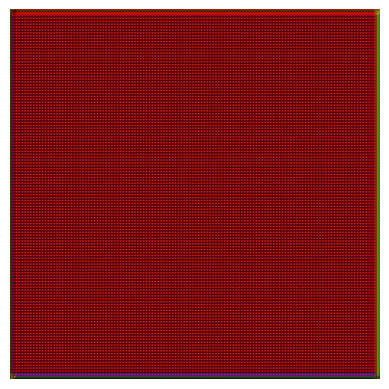

In [25]:
import matplotlib.pyplot as plt

gen = Geradora().to(device)

in01 = np.random.rand(10)


in01_t = torch.tensor(in01,dtype=torch.float32)
in01_t = in01_t.to(device)


x = gen(in01_t)
print(x)


x = x.detach().squeeze(0)

img = x.permute(1, 2, 0).cpu().numpy()

# Normalizar para [0,1] se necessário
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
gan = GAN().to(device)

in01_t = torch.tensor(in01,dtype=torch.float32)
in01_t = in01_t.to(device)

x = gan(in01_t)

print(x)

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_addmm)

In [10]:
def calculaMetricas(dataset,cnn):
    tabela_verdade = [
        [0, 0],  # classe 0
        [0, 0]   # classe 1
    ]

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True
    )


    for inputs, targets in train_loader:
        x_hat = cnn(inputs)
        classe = 0
        if x_hat[0] > 0.5:
            classe = 1
            
        #print(targets[0][0])
        tabela_verdade[classe][int(targets[0][0])]+=1
        
    print(tabela_verdade)

    print('   B','   NB')
    print('PB ',tabela_verdade[1][1],' ',tabela_verdade[1][0])
    print('PNB ',tabela_verdade[0][1],' ',tabela_verdade[0][0])

    VP = tabela_verdade[1][1]
    FP = tabela_verdade[1][0]
    FN = tabela_verdade[0][1]
    VN = tabela_verdade[0][0]
    Total = VP+FP+FN+VN
    ACC = (VP+VN)/Total
    PRE = VP/(VP+FP)
    REV = VP/(VP+FN)
    F1 = (PRE*REV/(PRE+REV))*2

    print("ACC ",ACC)
    print("PRE ",PRE)
    print("REV ",REV)
    print("F1 ",F1)

In [11]:
print("------------------- Treinamento ---------------------------------")
calculaMetricas(dataset,cnn)
print("------------------- TESTE ---------------------------------")
t_xtb = xb.to(device)
t_ytb = yb.to(device)
datasetb = TensorDataset(t_xtb, t_ytb)
calculaMetricas(datasetb,cnn)

------------------- Treinamento ---------------------------------
[[628, 134], [0, 0]]
   B    NB
PB  0   0
PNB  134   628


ZeroDivisionError: division by zero